In [125]:
# Прогноз результатов матчей на основе TrueSkill

from __future__ import print_function



In [ ]:
import pandas as pd
import trueskill

from math import sqrt, log
from trueskill import BETA
from trueskill.backends import cdf

Загружаем информацию про результаты игр, скачанную с http://dotascience.com/ и сразу сортируем по Match_ID.

In [44]:
matches_info = pd.read_csv('selected_team_matches.csv').sort(['match_id'])

In [45]:
matches_info

,date,tournament,radiant,dire,winner,match_id
0,2012-06-24,The Defense 2,WhA,EG,DIRE,22270148
1,2012-06-28,The Defense 2,Unknown,EG,DIRE,22959375
2,2012-06-29,StarSeries II Finals,EG,Empire,DIRE,23152391
3,2012-06-29,StarSeries II Finals,EG,NEXT.kz,RADIANT,23160256
4,2012-07-11,The Defense 2,EG,Unknown,DIRE,25449321
6,2012-07-17,BTS World Tour,Unknown,EG,DIRE,26649858
5,2012-07-17,BTS World Tour,EG,Unknown,RADIANT,26658780
7,2012-07-19,The Defense 2,EG,Unknown,RADIANT,27042254
8,2012-07-19,The Defense 2,Unknown,EG,DIRE,27051421
9,2012-07-27,The Defense 2,EG,Unknown,RADIANT,28705062


Инициализируем параметры Trueskill используя параметры по умолчанию, кроме вероятность ничейного результата, у нас не бывает ничьих.

In [ ]:
trueskill.setup(draw_probability=0)

Создадим словарик, где будем хранить рейтинги. И обучим нашу систему. Для каждого матча мы определим победителя и пересчитаем рейтинги комманд. Если команда раньше не встречалась задаем ей рейтинг по умочанию. В нашей простейшей модели мы считаем, что каждая команда это один виртуальный игрок.

In [ ]:
Rates = {}
for index, row in matches_info.iterrows():
    team1 = row['radiant']
    team2 = row['dire']
    if team1 not in Rates:
        Rates[team1] = trueskill.Rating()
    if team2 not in Rates:
        Rates[team2] = trueskill.Rating()
    if row['winner'] == 'RADIANT':
        Rates[team1], Rates[team2] = trueskill.rate_1vs1(Rates[team1], Rates[team2])
    else:
        Rates[team2], Rates[team1] = trueskill.rate_1vs1(Rates[team2], Rates[team1])
        

Теперь мы можем, например, насладится рейтингом команты Virtus.pro, которая скрывается под тагом 'VP 2' 

In [ ]:
Rates['VP 2']

Попробуем оценить вероятность победы Virtus.pro, например, в матче с Evil Genius.
К сожалению в библиотеке trueskill, нет возможности оценить вероятность, но мы же знаем из описания,
что рейтинги тут нормально распределенные. Так что сделаем функцию, которая оценит вероятность, 
что сила игры первой команды, будет больше чем у второй.

In [ ]:
def win_probability(player_rating, opponent_rating):
    delta_mu = player_rating.mu - opponent_rating.mu
    denom = sqrt(2 * (BETA * BETA) + pow(player_rating.sigma, 2) + pow(opponent_rating.sigma, 2))
    return cdf(delta_mu / denom)

Ура, теперь мы можем оценить шансы.

In [ ]:
win_probability(Rates['VP 2'], Rates['EG'])

In [ ]:
heroes_csv = pd.read_csv('heroes.csv')
print(heroes_csv)


In [ ]:
import requests
api_key = 'E80C0BAEE50452950C911FA18788536F'

In [684]:
def send(coeff):
    resp = requests.post('http://alchemist.dotascience.com/api/match/50/prediction', 
                         json={'team_id': 1838315, 'probability': coeff}, headers={'Key': api_key})
    resp = requests.get('http://alchemist.dotascience.com/api/match/50/prediction', headers={'Key': api_key})
    print(resp.json())
    #resp.json()
{'ok': True, 'time': 1457003701.0}

{'ok': True, 'time': 1457003701.0}

In [118]:
heroes_dict_name_by_id = {}
heroes_dict_id_by_name = {}
for l in heroes_csv.iterrows():
    #print(l)
    heroes_dict_name_by_id[l[1]['id']] = l[1]['localized_name']
    heroes_dict_id_by_name[l[1]['localized_name']] = l[1]['id']
    
#heroes_dict

In [53]:
class MatchInfo:
    def __init__(self, picks, radiant_name, dire_name, duration):
        self.picks = picks
        self.radiant_name = radiant_name
        self.dire_name = dire_name
        self.duration = duration
    

In [563]:
import json
X_train = []
Y_train = []
iter_num = 0
bad_count = 0
with open('selected_team_match_info.jsonlines', 'r') as matches_file:
    for line in matches_file:
        #print('iteration', iter_num)
        #print(line)
        match = json.loads(line)
        #print(match['match_id'])
        if (not 'picks_bans' in match) or (not 'radiant_win' in match):
            bad_count += 1
            continue
        radiant_win = match['radiant_win']
        
        list_radiant = []
        list_dire = []
        
        for pick_info in match['picks_bans']:
            if pick_info['is_pick'] == False:
                #print('BAN')
                continue
            #else:
                #print('PICK')
            side_radiant_flag = (pick_info['team'] == 0)
            hero_id = pick_info['hero_id']
            hero_name = heroes_dict_name_by_id[hero_id]
            if side_radiant_flag:
                list_radiant.append(hero_id)
            else:
                list_dire.append(hero_id)
            #print(pick_info)
        #print(match['picks_bans'])
        list_radiant = sorted(list_radiant)
        list_dire = sorted(list_dire)
        
        #print('Radiant', list_radiant)
        #print('Dire', list_dire)
        #print('flag', radiant_win)
        #if not 'radiant_name' in match:
        #    print(match)
        radiant_team_name = "" if not 'radiant_name' in match else match['radiant_name']
        dire_team_name = "" if not 'dire_name' in match else match['dire_name']
        duration = match['duration']
        #print("Radiant team: " + str(radiant_team_name + " Dire team: " + str(dire_team_name)))
        #print("Date: " + str(date))
        X_train.append(MatchInfo(list_radiant + list_dire, radiant_team_name, dire_team_name, duration))
        Y_train.append(radiant_win)
        iter_num += 1
        # Обработка матча
        #
#print(len(X_train))


In [93]:
X_train[0].picks

[19, 39, 91, 100, 101, 7, 25, 28, 85, 99]

In [ ]:
print(bad_count, len(X_train))

In [ ]:
from sklearn.neighbors import KDTree
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [110]:

class KDNN():
    def __init__(self):
        pass
    def fit(self, X_train, Y_train):
        self.X_train = X_train
        self.Y_train = Y_train
        return self
    def find_closest(self, X_test, k):
        dist = []
        for train_elem in range(len(self.X_train)):
            #print(self.X_train[train_elem].picks)
            assert len(self.X_train[train_elem].picks) == len(X_test)
            d = 0
            for j in range(len(self.X_train[train_elem].picks)):
                if self.X_train[train_elem].picks[j] != X_test[j]:
                    d += 1
            dist.append(d)
            #print("iteration " + str(i))
        dist = np.array(dist)
        return dist.argsort()[:k]
    def predict(self, X_test, k):
        num_test_objects = X_test.shape[0]
                #print("num_test_objects = " + str(num_test_objects))
        y_pred = np.zeros(num_test_objects)
        for i in range(num_test_objects):
            
            indexes = self.find_closest(X_test[i], k)
            #print("dist:")
            #print(dist)
            sum = 0
            #assert len(ind[0]) == k + 1
            #assert len(dist) == k + 1
            for index in indexes:
                #print("j = " + str(j))
                sum += self.Y_train[index]
            y_pred[i] = sum * 1.0 / k
        #print("len of y_pred = " + str(len(y_pred)), y_pred)
        assert len(y_pred) == num_test_objects
        return y_pred

In [111]:
def cross_validation(X, y, k, cv_fold=5):
    scores = []
    n = len(X)
    rnd_parts = np.random.randint(0, cv_fold, size=n)
    #print(rnd_parts)
    parts_x = [[] for x in range(cv_fold)]
    #print(parts_x)
    parts_y = [[] for x in range(cv_fold)]
    for j in range(n):
        parts_x[rnd_parts[j]].append(X[j])
        parts_y[rnd_parts[j]].append(y[j])
    for test_part in range(cv_fold):
        X_train = []
        Y_train = []
        for part in range(cv_fold):
            if test_part != part:
                X_train += parts_x[part]
                Y_train += parts_y[part]
        knn = KDNN()
        knn = knn.fit(np.asarray(X_train), np.asarray(Y_train))
        predicted = knn.predict(np.asarray(parts_x[test_part]), k)
        #assert len(predicted) == len(parts_x[test_part]), str(len(predicted)) + "!= " + str(len(parts_x[test_part]))
        #print("test x len = " + str(len(parts_x[test_part])))
        #plot_image(np.asarray(parts_x[test_part][0]))
        #print(parts_x[test_part])
        #print("y_pred len = " + str(len(predicted)))
        #print(predicted)
        rss = RSS(parts_y[test_part], predicted)
        #print("acc = " + str(acc))
        scores.append(rss)
    return np.mean(scores)


In [112]:
#make main KNN
knn = KDNN()
knn = knn.fit(X_train, Y_train)

In [88]:
def test_model_1ex(radiant_names, dire_names, k):
    radiant = []
    dire = []
    for name in radiant_names:
        radiant.append(heroes_dict_id_by_name[name])
    for name in dire_names:
        dire.append(heroes_dict_id_by_name[name])
    radiant = sorted(radiant)
    dire = sorted(dire)
    X_test = [radiant + dire]
    predict_res = knn.predict(np.asarray(X_test), k)
    return predict_res

In [ ]:
import bz2
import json
import pprint
#print(heroes_csv[1])
calculated_matches = {}
with bz2.BZ2File('shanghai_live_league_games.jsonlines.bz2') as f: 
    for line in f:
        record = json.loads(line)
        #print(record)
        #break
        if 'scoreboard' in record:
            duration = record['scoreboard']['duration']
        elif 'duration' in record:
            duration = record['duration']
        else:
            continue
        if duration < 300:
            continue
        match_id = int(record['match_id'])
        #print('match id   ' + str(match_id))
        if match_id in calculated_matches:
            continue
        calculated_matches[match_id] = 1
        print("radiant name " + str(record['radiant_team']['team_name']) + " id = " + str(record['radiant_team']['team_id']))
        print("dire name " + str(record['dire_team']['team_name']) + " id = " + str(record['dire_team']['team_id']))
        
        
        radiant_list = []
        dire_list = []
        #pprint.pprint(record)
        match_id = record['match_id']
        for pl in record['players']:
            if pl['team'] <= 1:
                hero_id = pl['hero_id']
                assert hero_id != 0
                if pl['team'] == 0:
                    radiant_list.append(hero_id)
                else:
                    dire_list.append(hero_id)
                #print(heroes_dict_name_by_id[pl['hero_id']], pl['name'])
                #print(pl['hero_id'], pl['name'])   
        X_test = radiant_list + dire_list
        #print('X_test')
        #for j in X_test:
        #    print(heroes_dict_name_by_id[j])
        y_pred = knn.predict(np.asarray([X_test]), 50)
        print("predicted: " + str(y_pred))
        #break
        # process record

In [140]:
def find_closest(radiant_names, dire_names, k):
    radiant = []
    dire = []
    for name in radiant_names:
        radiant.append(heroes_dict_id_by_name[name])
    for name in dire_names:
        dire.append(heroes_dict_id_by_name[name])
    radiant = sorted(radiant)
    dire = sorted(dire)
    X_test = radiant + dire
    closest_list = knn.find_closest(X_test, k)
    for number in closest_list:
        game = knn.X_train[number]
        print('========================\nnumber = ' + str(number))
        print('Radiant pick:')
        for i in range(5):
            print(heroes_dict_name_by_id[game.picks[i]], end=' ')
        print('\nDire pick:')
        for i in range(5, 10):
            print(heroes_dict_name_by_id[game.picks[i]], end=' ')
        print('\nRadiant team: ' + game.radiant_name)
        print('Dire team: ' + game.dire_name)
        print('Duration: ' + str(game.duration))
        
            
    #return predict_res

In [ ]:
radiant_names = ['Earth Spirit', 'Lion', 'Invoker', 'Slark', 'Beastmaster']
dire_names = ['Rubick', 'Death Prophet', 'Tusk', 'Nature\'s Prophet', 'Outworld Devourer']
find_closest(radiant_names, dire_names, 5)

In [675]:
xpm_scatter_x = []
xpm_scatter_y = []
gpm_scatter_x = []
gpm_scatter_y = []

In [676]:
import json
import matplotlib.pyplot as plt
from json2html import *
from IPython.display import HTML
%matplotlib inline

resp = requests.get('http://alchemist.dotascience.com/api/match/49/status', headers={'Key': api_key})
resp_json = resp.json()
#with open('tmp.json', 'w') as txtfile:
#    json.dump(resp_json, txtfile)
#print(resp_json)
lh_dict = {}
net_worth_dict = {}
gpm_dict = {}
xpm_dict = {}
sum_gpm = {'dire' : 0, 'radiant' : 0}
sum_xpm = {'dire' : 0, 'radiant' : 0}
for side in ['dire', 'radiant']:
    for j in range(5):
        pl = resp_json['live_info']['scoreboard'][side]['players'][j]
        gpm = pl['gold_per_min']
        xpm = pl['xp_per_min']
        net_worth = pl['net_worth']
        hero_id = pl['hero_id']
        hero_name = heroes_dict_name_by_id[hero_id]
        lh = pl['last_hits']
        #print("gpm = " + str(gpm) + " net_worth = " + str(net_worth) + " hero_name = " + str(hero_name), " lasthits = " + str(lh))
        full_name = hero_name + ' (' + side + ')'
        lh_dict[full_name] = lh
        net_worth_dict[full_name] = net_worth
        gpm_dict[full_name] = gpm
        xpm_dict[full_name] = xpm
        sum_gpm[side] += gpm
        sum_xpm[side] += xpm
#plt.scatter(lh_dict.keys(), lh_dict.values())
#print(lh_dict)
print('SUMXPM: ' + str(sum_xpm['radiant']) + "/" + str(sum_xpm['dire']))
print('SUMGPM: ' + str(sum_gpm['radiant']) + "/" + str(sum_gpm['dire']))
diff_xpm = int(sum_xpm['radiant']) - int(sum_xpm['dire'])
diff_gpm = int(sum_gpm['radiant']) - int(sum_gpm['dire'])
dur = resp_json['live_info']['scoreboard']['duration']
xpm_scatter_x.append(dur)
xpm_scatter_y.append(diff_xpm)
gpm_scatter_x.append(dur)
gpm_scatter_y.append(diff_gpm)




    
#with open('data.json', 'w') as outfile:
#    json.dump(resp.json(), outfile)
    

SUMXPM: 2087/2020
SUMGPM: 2085/1946


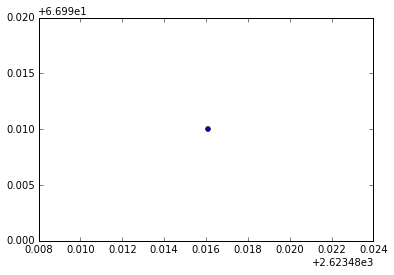

In [677]:
#DIFF IN XPM
plt.scatter(xpm_scatter_x, xpm_scatter_y)

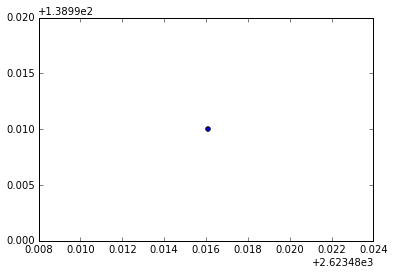

In [678]:
#DIFF IN GPM
plt.scatter(gpm_scatter_x, gpm_scatter_y)

In [679]:
#LASTHITS
display(lh_dict)

                       0    1
0      Invoker (radiant)  310
1  Lycanthrope (radiant)  286
2       Dark Seer (dire)  252
3   Death Prophet (dire)  215
4            Ursa (dire)  209
5  Beastmaster (radiant)  206
6   Winter Wyvern (dire)  143
7       Oracle (radiant)   87
8            Lion (dire)   39
9         Tusk (radiant)   38


In [680]:
#NETWORTH
display(net_worth_dict)

                       0      1
0      Invoker (radiant)  24233
1  Lycanthrope (radiant)  23317
2   Death Prophet (dire)  18565
3       Dark Seer (dire)  15919
4            Ursa (dire)  15602
5  Beastmaster (radiant)  13814
6   Winter Wyvern (dire)   9345
7       Oracle (radiant)   8906
8         Tusk (radiant)   6835
9            Lion (dire)   5086


In [681]:
#GPM
display(gpm_dict)

                       0    1
0      Invoker (radiant)  606
1  Lycanthrope (radiant)  565
2   Death Prophet (dire)  524
3            Ursa (dire)  458
4       Dark Seer (dire)  443
5  Beastmaster (radiant)  402
6   Winter Wyvern (dire)  313
7       Oracle (radiant)  264
8         Tusk (radiant)  248
9            Lion (dire)  208


In [682]:
#XPM
display(xpm_dict)

                       0    1
0   Death Prophet (dire)  577
1            Ursa (dire)  534
2      Invoker (radiant)  525
3  Lycanthrope (radiant)  518
4  Beastmaster (radiant)  491
5       Dark Seer (dire)  355
6   Winter Wyvern (dire)  333
7         Tusk (radiant)  289
8       Oracle (radiant)  264
9            Lion (dire)  221


In [694]:
send(0.0)

{u'match_id': 50, u'predictions': [{u'team_id': 1838315, u'probability': 0.0, u'time': 1457255762.0}, {u'team_id': 1838315, u'probability': 0.0, u'time': 1457256261.0}, {u'team_id': 1838315, u'probability': 0.0, u'time': 1457256346.0}, {u'team_id': 1838315, u'probability': 0.0, u'time': 1457256579.0}, {u'team_id': 1838315, u'probability': 0.0, u'time': 1457257019.0}, {u'team_id': 1838315, u'probability': 0.0, u'time': 1457257262.0}, {u'team_id': 1838315, u'probability': 0.5, u'time': 1457257488.0}, {u'team_id': 1838315, u'probability': 1.0, u'time': 1457257595.0}, {u'team_id': 1838315, u'probability': 0.0, u'time': 1457257676.0}], u'account_name': u'hack__mipt_rak'}
